In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [89]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
#print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)





,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [90]:
secopI_filter = secop_I[
    ['id_modalidad', 'estado_del_proceso', 'id_objeto_a_contratar', 'tipo_de_contrato', 'departamento_ejecucion',
     'municipios_ejecucion_', 'cuantia_proceso', 'id_grupo',
     'id_familia', 'id_clase', 'plazo_de_ejec_del_contrato_', 'tiempo_adiciones_en_dias', 'dias_ejec_final_contrato']]

secopI_filter
secopI_filter.columns
base = secopI_filter
n = base.isna() == True
base = base.fillna(0)
base.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id_modalidad                 26553 non-null  Int64 
 1   estado_del_proceso           26553 non-null  object
 2   id_objeto_a_contratar        26553 non-null  Int64 
 3   tipo_de_contrato             26553 non-null  object
 4   departamento_ejecucion       26553 non-null  object
 5   municipios_ejecucion_        26553 non-null  object
 6   cuantia_proceso              26553 non-null  Int64 
 7   id_grupo                     26553 non-null  object
 8   id_familia                   26553 non-null  object
 9   id_clase                     26553 non-null  object
 10  plazo_de_ejec_del_contrato_  26553 non-null  Int64 
 11  tiempo_adiciones_en_dias     26553 non-null  Int64 
 12  dias_ejec_final_contrato     26553 non-null  Int64 
dtypes: Int64(6), object(7)
memory u

In [91]:
# Codificación de las variables categoricas
base['estado_del_proceso'] = pd.factorize(base.estado_del_proceso)[0]
base['tipo_de_contrato'] = pd.factorize(base.tipo_de_contrato)[0]
base['departamento_ejecucion'] = pd.factorize(base.departamento_ejecucion)[0]
base['municipios_ejecucion_'] = pd.factorize(base.municipios_ejecucion_)[0]
base['id_grupo'] = pd.factorize(base.id_grupo)[0]
base['id_familia'] = pd.factorize(base.id_familia)[0]
base['id_clase'] = pd.factorize(base.id_clase)[0]
base['plazo_de_ejec_del_contrato_'] = pd.factorize(base.plazo_de_ejec_del_contrato_)[0]

In [92]:
df = base
df.columns

Index(['id_modalidad', 'estado_del_proceso', 'id_objeto_a_contratar',
       'tipo_de_contrato', 'departamento_ejecucion', 'municipios_ejecucion_',
       'cuantia_proceso', 'id_grupo', 'id_familia', 'id_clase',
       'plazo_de_ejec_del_contrato_', 'tiempo_adiciones_en_dias',
       'dias_ejec_final_contrato'],
      dtype='object')

<Axes: >

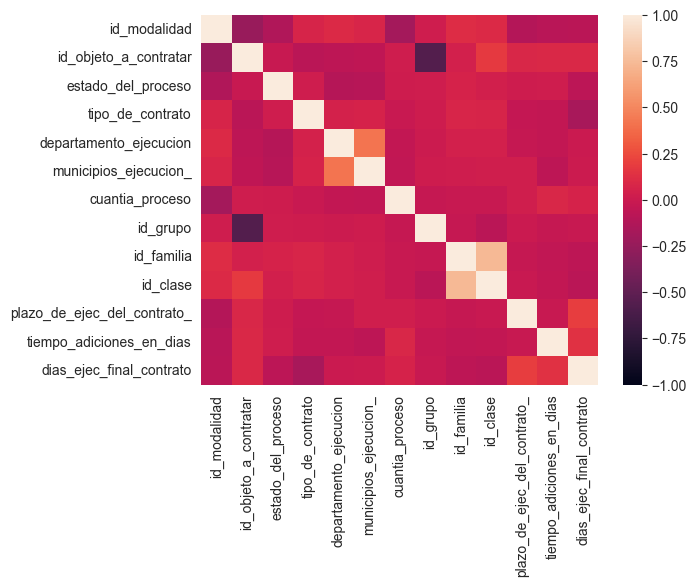

In [93]:
import seaborn as sns
sns.heatmap(df[["id_modalidad", "id_objeto_a_contratar", "estado_del_proceso", "tipo_de_contrato", "departamento_ejecucion","municipios_ejecucion_","cuantia_proceso","id_grupo","id_familia", "id_clase","plazo_de_ejec_del_contrato_","tiempo_adiciones_en_dias","dias_ejec_final_contrato" ]].corr(), vmin=-1, vmax=1, annot=False)


In [110]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)


train_X = train_dataset.drop(['tiempo_adiciones_en_dias'], axis=1)
test_X = test_dataset.drop(['tiempo_adiciones_en_dias'], axis=1)

In [111]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
id_modalidad,21242.0,12.850909,0.537507,1.0,13.0,13.0,13.0,19.0
estado_del_proceso,21242.0,0.666651,0.867649,0.0,0.0,0.0,1.0,6.0
id_objeto_a_contratar,21242.0,47790603.521326,19854229.145802,10000000.0,44000000.0,50000000.0,53000000.0,95000000.0
tipo_de_contrato,21242.0,2.136098,2.327779,0.0,0.0,1.0,5.0,9.0
departamento_ejecucion,21242.0,8.671924,6.699319,0.0,3.0,8.0,12.0,30.0
municipios_ejecucion_,21242.0,46.552208,40.594633,0.0,10.0,36.0,78.0,227.0
cuantia_proceso,21242.0,19836893.112607,178561205.183926,0.0,1500000.0,4522639.0,16000000.0,22980096902.0
id_grupo,21242.0,1.139488,1.814365,0.0,0.0,0.0,1.0,6.0
id_familia,21242.0,75.602486,63.051993,0.0,37.0,50.0,92.0,299.0
id_clase,21242.0,205.27987,205.354927,0.0,63.0,89.0,378.0,958.0


In [112]:
train_labels = train_dataset.pop('tiempo_adiciones_en_dias')
test_labels = test_dataset.pop('tiempo_adiciones_en_dias')

In [113]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [114]:
[len(train_dataset.keys())]

[12]

In [192]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(6, activation='relu'),
    layers.Dense(3, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [193]:
model = build_model()

In [194]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 12)                156       
                                                                 
 dense_59 (Dense)            (None, 6)                 78        
                                                                 
 dense_60 (Dense)            (None, 3)                 21        
                                                                 
 dense_61 (Dense)            (None, 1)                 4         
                                                                 
Total params: 259 (1.01 KB)
Trainable params: 259 (1.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [195]:
train_data = np.asarray(normed_train_data).astype(np.float32)
test_data = np.asarray(normed_test_data).astype(np.float32)


In [196]:
example_batch = train_data[:]
example_result = model.predict(example_batch)
example_result

664/664 [==============================] - 0s 353us/step


array([[ 0.        ],
       [-0.00828671],
       [-0.05778314],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [197]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [198]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

          loss       mae        mse    val_loss   val_mae     val_mse  epoch
0    93.659782  1.302501  93.659782  116.943939  1.647434  116.943939      0
1    93.142967  1.511497  93.142967  116.243439  1.864995  116.243439      1
2    92.627090  1.652705  92.627090  115.231308  1.962945  115.231308      2
3    91.420174  1.734975  91.420174  112.777939  2.066658  112.777939      3
4    89.108665  1.881201  89.108665  109.106903  2.116776  109.106903      4
..         ...       ...        ...         ...       ...         ...    ...
195  55.892708  1.335451  55.892708   74.961952  1.515531   74.961952    195
196  56.201431  1.327650  56.201431   74.163506  1.612954   74.163506    196
197  56.067978  1.373296  56.067978   75.185966  1.368016   75.185966    197
198  56.036819  1.360541  56.036819   74.866859  1.317985   74.866859    198
199  56.194187  1.347892  56.194187   74.277725  1.680041   74.277725    199

[200 rows x 7 columns]


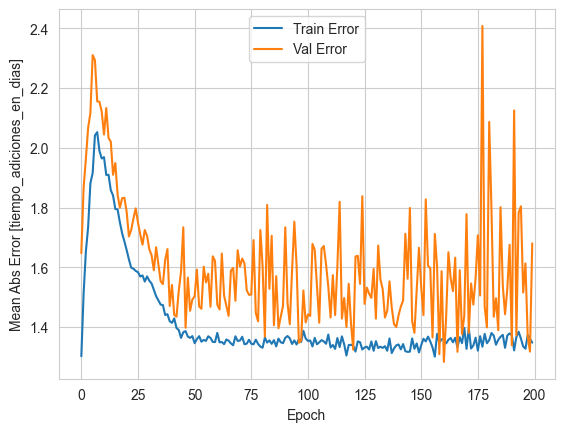

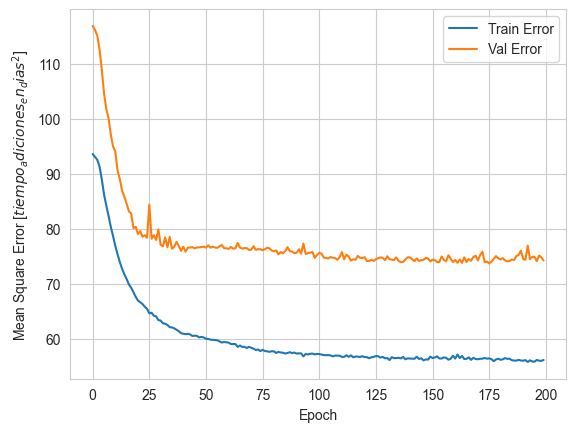

In [199]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [tiempo_adiciones_en_dias]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$tiempo_adiciones_en_dias^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [200]:
model_imp = build_model()

In [201]:
test_data = np.asarray(normed_test_data).astype(np.float32)
example_result = model_imp.predict(np.array(test_data[:]))
resultados = pd.DataFrame(example_result)
resultados.columns = ['resultados']
print(resultados)

166/166 [==============================] - 0s 546us/step
      resultados
0      -0.028163
1       0.011567
2       0.016765
3       0.016928
4       0.016928
...          ...
5306    0.054248
5307   -0.067394
5308   -0.069628
5309   -0.162917
5310   -0.096659

[5311 rows x 1 columns]


In [202]:
test_data = np.asarray(normed_test_data).astype(np.float32)

In [203]:
test_labels = pd.DataFrame(test_labels)
compare = pd.concat([resultados, test_labels], axis=1)
compare = compare.fillna(0)

In [204]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_t = mean_squared_error(compare['resultados'], compare['tiempo_adiciones_en_dias'])
mae_t = mean_absolute_error(compare['resultados'], compare['tiempo_adiciones_en_dias'])
print("El MSE entre las columnas 'Modelo' y 'Dato' es:", mse_t)
print("El MAE entre las columnas 'Modelo' y 'Dato' es:", mae_t)


El MSE entre las columnas 'Modelo' y 'Dato' es: 41.828540245654736
El MAE entre las columnas 'Modelo' y 'Dato' es: 0.6233345052426896
